In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import *
import numpy as np
%matplotlib inline

## Подготовка и визуализация данных

In [2]:
train_loader, valid_loader, test_loader = mnist(valid=10000, batch_size=50)

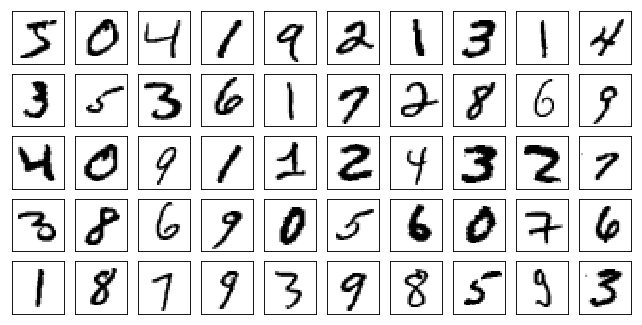

In [3]:
images = mnist_plotdata()
plot_mnist(images, (5, 10))

## Обучение классификатора

In [38]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=1e-4, l2=0.):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        if batchnorm:
            self.bn = nn.BatchNorm1d(256)
        self.batchnorm = batchnorm
        
        self.dropout = dropout
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2)
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        if self.batchnorm:
            x = self.bn(x)
        x = F.relu(self.fc2(x))
        if self.dropout:
            x = F.dropout(x, 0.5)
        x = self.fc3(x)    
        x = F.log_softmax(x, dim=1)
        return x
    
    def loss(self, output, target, **kwargs):
        self._loss = F.nll_loss(output, target, **kwargs)
        return self._loss

In [16]:
def train(epoch, models):
    loss_stats = np.empty((0,4))
    
    train_size = len(train_loader.sampler)
    for batch_idx, (data, target) in enumerate(train_loader):
       
        for model in models:
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()                
            
            
        if batch_idx % 200 == 0:
            print_stats(models, train_loader, epoch, batch_idx, data, train_size)            
            stats_line = np.array([m._loss.item() for m in models])
            loss_stats = np.vstack([loss_stats, stats_line])          
            
    else:
        batch_idx += 1
        print_stats(models, train_loader, epoch, batch_idx, data, train_size)
        stats_line = np.array([m._loss.item() for m in models])
        loss_stats = np.vstack([loss_stats, stats_line])
       
    epoch_loss = np.mean(loss_stats, axis=0)      
    return epoch_loss
       
        
def print_stats(models, train_loader, epoch, batch_idx, data, train_size):
    line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
    losses = ' '.join(['{}: {:.6f}'.format(i, m._loss.item()) for i, m in enumerate(models)])
    print(line + losses)
        

In [17]:
models = [Net(False, False), Net(True, False), Net(False, True), Net(True, True)]

In [18]:
def test(models, loader):
    test_size = len(loader.sampler)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = [0]*len(models)
    correct = [0]*len(models)
    with torch.no_grad():
        for data, target in loader:
            output = [m(data) for m in models]
            for i, m in enumerate(models):
                test_loss[i] += m.loss(output[i], target, size_average=False).item() # sum up batch loss
                pred = output[i].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[i] += pred.eq(target.data.view_as(pred)).cpu().sum()
    
    for i in range(len(models)):
        test_loss[i] /= test_size
    correct_pct = [100. * c / test_size for c in correct]
    lines = '\n'.join([line(i, test_loss[i], correct[i], correct_pct[i]) for i in range(len(models))]) + '\n'
    report = 'Test set:\n' + lines
    
    print(report)
    
    return test_loss, correct_pct

In [19]:
epoch_train_loss = []
epoch_test_loss = []
epoch_test_acc = []

In [20]:
for epoch in range(1, 21):
    for model in models:
        model.train()
    train_loss_val = train(epoch, models)
    epoch_train_loss.append(train_loss_val)
    
    for model in models:
        model.eval()
    test_loss_val, test_acc_val = test(models, valid_loader)
    epoch_test_loss.append(test_loss_val)
    epoch_test_acc.append(test_acc_val)
    

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Train Epoch: 1 [0/50000 (0%)]	Losses 0: 2.327425 1: 2.340549 2: 2.296613 3: 2.290284
Train Epoch: 1 [10000/50000 (20%)]	Losses 0: 0.528703 1: 0.646311 2: 0.522253 3: 0.682473
Train Epoch: 1 [20000/50000 (40%)]	Losses 0: 0.300755 1: 0.297055 2: 0.292518 3: 0.301515
Train Epoch: 1 [30000/50000 (60%)]	Losses 0: 0.491225 1: 0.382450 2: 0.479021 3: 0.388505
Train Epoch: 1 [40000/50000 (80%)]	Losses 0: 0.388524 1: 0.344619 2: 0.382316 3: 0.344652
Train Epoch: 1 [50000/50000 (100%)]	Losses 0: 0.210931 1: 0.185536 2: 0.231152 3: 0.204111
Test set:
0: Loss: 0.2578	Accuracy: 9232/10000 (92%)
1: Loss: 0.1998	Accuracy: 9418/10000 (94%)
2: Loss: 0.2527	Accuracy: 9243/10000 (92%)
3: Loss: 0.2102	Accuracy: 9383/10000 (93%)

Train Epoch: 2 [0/50000 (0%)]	Losses 0: 0.446509 1: 0.342857 2: 0.428970 3: 0.378852
Train Epoch: 2 [10000/50000 (20%)]	Losses 0: 0.185910 1: 0.140166 2: 0.172756 3: 0.162060
Train Epoch: 2 [20000/50000 (40%)]	Losses 0: 0.229983 1: 0.189725 2: 0.207024 3: 0.226461
Train Epoch: 2 [

Train Epoch: 12 [40000/50000 (80%)]	Losses 0: 0.075219 1: 0.045865 2: 0.056565 3: 0.055696
Train Epoch: 12 [50000/50000 (100%)]	Losses 0: 0.082602 1: 0.057633 2: 0.064620 3: 0.040889
Test set:
0: Loss: 0.0919	Accuracy: 9732/10000 (97%)
1: Loss: 0.0803	Accuracy: 9795/10000 (97%)
2: Loss: 0.0849	Accuracy: 9761/10000 (97%)
3: Loss: 0.0788	Accuracy: 9784/10000 (97%)

Train Epoch: 13 [0/50000 (0%)]	Losses 0: 0.049020 1: 0.014964 2: 0.047294 3: 0.018037
Train Epoch: 13 [10000/50000 (20%)]	Losses 0: 0.042093 1: 0.008380 2: 0.030662 3: 0.009727
Train Epoch: 13 [20000/50000 (40%)]	Losses 0: 0.012305 1: 0.002360 2: 0.006216 3: 0.011906
Train Epoch: 13 [30000/50000 (60%)]	Losses 0: 0.069471 1: 0.018460 2: 0.056218 3: 0.009554
Train Epoch: 13 [40000/50000 (80%)]	Losses 0: 0.011594 1: 0.068560 2: 0.008868 3: 0.022940
Train Epoch: 13 [50000/50000 (100%)]	Losses 0: 0.006807 1: 0.000464 2: 0.002929 3: 0.001421
Test set:
0: Loss: 0.0870	Accuracy: 9753/10000 (97%)
1: Loss: 0.0856	Accuracy: 9779/10000 (9

In [21]:
final_train_loss = np.array(epoch_train_loss)
final_test_loss = np.array(epoch_test_loss)
final_test_acc = np.array(epoch_test_acc)

In [22]:
torch.save(models[3], './model_classifier')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Вывод результатов

In [28]:
model = torch.load('./model_classifier')

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


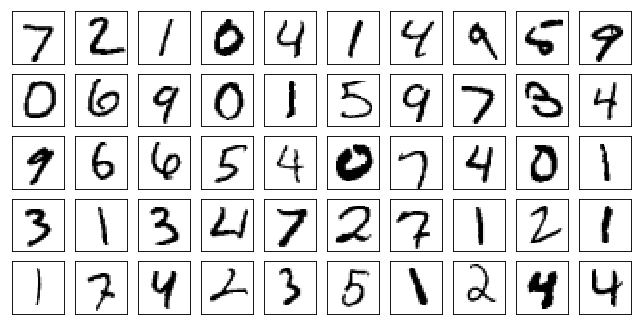

[tensor(7), tensor(2), tensor(1), tensor(0), tensor(4), tensor(1), tensor(4), tensor(9), tensor(5), tensor(9), tensor(0), tensor(6), tensor(9), tensor(0), tensor(1), tensor(5), tensor(9), tensor(7), tensor(3), tensor(4), tensor(9), tensor(6), tensor(6), tensor(5), tensor(4), tensor(0), tensor(7), tensor(4), tensor(0), tensor(1), tensor(3), tensor(1), tensor(3), tensor(4), tensor(7), tensor(2), tensor(7), tensor(1), tensor(2), tensor(1), tensor(1), tensor(7), tensor(4), tensor(2), tensor(3), tensor(5), tensor(1), tensor(2), tensor(4), tensor(4)]


In [60]:
data, _ = next(iter(test_loader))
output = model.forward(data)
predictions = [output[i].argmax() for i in range(50)]
plot_mnist(data.data.numpy(), (5, 10))

print (predictions)

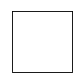

In [112]:
data, _ = next(iter(test_loader))
img = torch.ones((784))
#img = data[2]
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (1, 1))


In [113]:
from torch.autograd import Variable

def generate_image(img, cl):
    
    gen_img_par = Variable(img, requires_grad=True)    
    target = torch.ones((10)) * 0.01
    target[cl] = 0.99
    target = target.view(1, 10)
    
    loss_stats = []    
    gen_optim = optim.Adam([gen_img_par], lr=1e-4, weight_decay=0.5)

    for i in range(1, 1000001):  
                
        out = torch.exp(model.forward(gen_img_par))    
                 
        gen_optim.zero_grad()
        loss = F.mse_loss(out, target)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 2000 == 0:    
            print ("Iteration {}: loss={} prediction={}".format(i,loss, out.argmax()))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
            
            #print("PRED=", out.argmax())
            #print("OUT=", out)
            #print("TR=", target)
                        
            if len(loss_stats) > 200:    
                if ls > loss_stats[-2] and ls > loss_stats[-3] and ls > loss_stats[-4] and ls > loss_stats[-5]:
                    print ("Loss is rising .. stop")
                    break

        if i % 20000 == 0:
            to_plot = gen_img_par.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (1, 1))
                        
    return gen_img_par    

/Users/aleksey/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration 2000: loss=0.19609743356704712 prediction=4
Iteration 4000: loss=0.19606894254684448 prediction=4
Iteration 6000: loss=0.19571243226528168 prediction=4
Iteration 8000: loss=0.14494116604328156 prediction=4
Iteration 10000: loss=0.0010308314813300967 prediction=2
Iteration 12000: loss=0.00013363076141104102 prediction=2
Iteration 14000: loss=0.00020618045527953655 prediction=2
Iteration 16000: loss=0.00021796164219267666 prediction=2
Iteration 18000: loss=0.0002180443552788347 prediction=2
Iteration 20000: loss=0.00021801159891765565 prediction=2


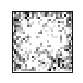

Iteration 22000: loss=0.00021870345517527312 prediction=2
Iteration 24000: loss=0.0002194827247876674 prediction=2
Iteration 26000: loss=0.00021938739519100636 prediction=2
Iteration 28000: loss=0.00022166808776091784 prediction=2
Iteration 30000: loss=0.0002217818982899189 prediction=2
Iteration 32000: loss=0.00021377333905547857 prediction=2
Iteration 34000: loss=0.00022336133406497538 prediction=2
Iteration 36000: loss=0.00021417532116174698 prediction=2
Iteration 38000: loss=0.0002206300850957632 prediction=2
Iteration 40000: loss=0.0002158705610781908 prediction=2


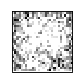

Iteration 42000: loss=0.00021696242038160563 prediction=2
Iteration 44000: loss=0.0002215863496530801 prediction=2
Iteration 46000: loss=0.00021377939265221357 prediction=2
Iteration 48000: loss=0.00022336342954076827 prediction=2
Iteration 50000: loss=0.00021417252719402313 prediction=2
Iteration 52000: loss=0.0002206312055932358 prediction=2
Iteration 54000: loss=0.00021587216178886592 prediction=2
Iteration 56000: loss=0.00021696242038160563 prediction=2
Iteration 58000: loss=0.00022158733918331563 prediction=2
Iteration 60000: loss=0.00021377885423135012 prediction=2


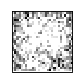

Iteration 62000: loss=0.00022336440451908857 prediction=2
Iteration 64000: loss=0.00021417516109067947 prediction=2
Iteration 66000: loss=0.00022063271899241954 prediction=2
Iteration 68000: loss=0.00021587114315479994 prediction=2
Iteration 70000: loss=0.00021696244948543608 prediction=2
Iteration 72000: loss=0.00022158687352202833 prediction=2
Iteration 74000: loss=0.00021377790835686028 prediction=2
Iteration 76000: loss=0.0002233623235952109 prediction=2
Iteration 78000: loss=0.00021417462266981602 prediction=2
Iteration 80000: loss=0.00022063215146772563 prediction=2


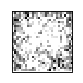

Iteration 82000: loss=0.00021587366063613445 prediction=2
Iteration 84000: loss=0.00021696093608625233 prediction=2
Iteration 86000: loss=0.00022158733918331563 prediction=2
Iteration 88000: loss=0.00021377878147177398 prediction=2
Iteration 90000: loss=0.0002233617997262627 prediction=2
Iteration 92000: loss=0.00021417481184471399 prediction=2
Iteration 94000: loss=0.00022063164215069264 prediction=2
Iteration 96000: loss=0.0002158706047339365 prediction=2
Iteration 98000: loss=0.00021696186740882695 prediction=2
Iteration 100000: loss=0.0002215873246314004 prediction=2


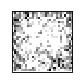

Iteration 102000: loss=0.00021377738448791206 prediction=2
Iteration 104000: loss=0.00022336238180287182 prediction=2
Iteration 106000: loss=0.00021417364769149572 prediction=2
Iteration 108000: loss=0.00022063113283365965 prediction=2
Iteration 110000: loss=0.00021587099763564765 prediction=2
Iteration 112000: loss=0.00021696295880246907 prediction=2
Iteration 114000: loss=0.0002215862477896735 prediction=2
Iteration 116000: loss=0.00021377726807259023 prediction=2
Iteration 118000: loss=0.00022336130496114492 prediction=2
Iteration 120000: loss=0.0002141752338502556 prediction=2


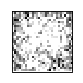

Iteration 122000: loss=0.00022063113283365965 prediction=2
Iteration 124000: loss=0.00021587355877272785 prediction=2
Iteration 126000: loss=0.00021696400654036552 prediction=2
Iteration 128000: loss=0.00022158640786074102 prediction=2
Iteration 130000: loss=0.00021377683151513338 prediction=2
Iteration 132000: loss=0.00022336290567182004 prediction=2
Iteration 134000: loss=0.00021417424432002008 prediction=2
Iteration 136000: loss=0.00022063271899241954 prediction=2
Iteration 138000: loss=0.00021587262745015323 prediction=2
Iteration 140000: loss=0.00021696144540328532 prediction=2


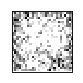

Iteration 142000: loss=0.00022158806677907705 prediction=2
Iteration 144000: loss=0.00021377830125857145 prediction=2
Iteration 146000: loss=0.00022336337133310735 prediction=2
Iteration 148000: loss=0.00021417372045107186 prediction=2
Iteration 150000: loss=0.00022063164215069264 prediction=2
Iteration 152000: loss=0.00021587256924249232 prediction=2
Iteration 154000: loss=0.0002169618383049965 prediction=2
Iteration 156000: loss=0.0002215873682871461 prediction=2
Iteration 158000: loss=0.00021377686061896384 prediction=2
Iteration 160000: loss=0.00022336181427817792 prediction=2


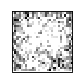

Iteration 162000: loss=0.00021417361858766526 prediction=2
Iteration 164000: loss=0.00022063327196519822 prediction=2
Iteration 166000: loss=0.00021587169612757862 prediction=2
Iteration 168000: loss=0.00021696176554542035 prediction=2
Iteration 170000: loss=0.00022158797946758568 prediction=2
Iteration 172000: loss=0.00021377691882662475 prediction=2
Iteration 174000: loss=0.00022336239635478705 prediction=2
Iteration 176000: loss=0.0002141736913472414 prediction=2
Iteration 178000: loss=0.00022063117648940533 prediction=2
Iteration 180000: loss=0.0002158725110348314 prediction=2


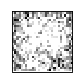

Iteration 182000: loss=0.00021696140174753964 prediction=2
Iteration 184000: loss=0.00022158739739097655 prediction=2
Iteration 186000: loss=0.00021377691882662475 prediction=2
Iteration 188000: loss=0.00022336184338200837 prediction=2
Iteration 190000: loss=0.00021417562675196677 prediction=2
Iteration 192000: loss=0.00022063071082811803 prediction=2
Iteration 194000: loss=0.0002158715797122568 prediction=2
Iteration 196000: loss=0.0002169625659007579 prediction=2
Iteration 198000: loss=0.0002215859421994537 prediction=2
Iteration 200000: loss=0.00021377876691985875 prediction=2


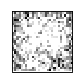

Iteration 202000: loss=0.00022336127585731447 prediction=2
Iteration 204000: loss=0.00021417267271317542 prediction=2
Iteration 206000: loss=0.00022063062351662666 prediction=2
Iteration 208000: loss=0.0002158716815756634 prediction=2
Iteration 210000: loss=0.00021696036856155843 prediction=2
Iteration 212000: loss=0.00022158792125992477 prediction=2
Iteration 214000: loss=0.00021377732628025115 prediction=2
Iteration 216000: loss=0.00022336244001053274 prediction=2
Iteration 218000: loss=0.00021417372045107186 prediction=2
Iteration 220000: loss=0.0002206337812822312 prediction=2


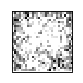

Iteration 222000: loss=0.00021587002265732735 prediction=2
Iteration 224000: loss=0.0002169613289879635 prediction=2
Iteration 226000: loss=0.0002215883432654664 prediction=2
Iteration 228000: loss=0.00021377831581048667 prediction=2
Iteration 230000: loss=0.0002233634004369378 prediction=2
Iteration 232000: loss=0.00021417772222775966 prediction=2
Iteration 234000: loss=0.00022063222422730178 prediction=2
Iteration 236000: loss=0.000215872103581205 prediction=2
Iteration 238000: loss=0.000216961998376064 prediction=2
Iteration 240000: loss=0.00022158636420499533 prediction=2


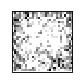

Iteration 242000: loss=0.0002137788978870958 prediction=2
Iteration 244000: loss=0.00022336289111990482 prediction=2
Iteration 246000: loss=0.00021417559764813632 prediction=2
Iteration 248000: loss=0.00022063066717237234 prediction=2
Iteration 250000: loss=0.00021587207447737455 prediction=2
Iteration 252000: loss=0.00021696249314118177 prediction=2
Iteration 254000: loss=0.0002215863496530801 prediction=2
Iteration 256000: loss=0.0002137772971764207 prediction=2
Iteration 258000: loss=0.00022336235269904137 prediction=2
Iteration 260000: loss=0.00021417567040771246 prediction=2


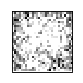

Iteration 262000: loss=0.00022063210781197995 prediction=2
Iteration 264000: loss=0.00021587309311144054 prediction=2
Iteration 266000: loss=0.00021696239127777517 prediction=2
Iteration 268000: loss=0.00022158795036375523 prediction=2
Iteration 270000: loss=0.00021377736993599683 prediction=2
Iteration 272000: loss=0.00022336289111990482 prediction=2
Iteration 274000: loss=0.00021417315292637795 prediction=2
Iteration 276000: loss=0.00022063222422730178 prediction=2
Iteration 278000: loss=0.000215872612898238 prediction=2
Iteration 280000: loss=0.00021696145995520055 prediction=2


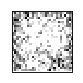

Iteration 282000: loss=0.0002215873682871461 prediction=2
Iteration 284000: loss=0.00021377783559728414 prediction=2
Iteration 286000: loss=0.00022336402616929263 prediction=2
Iteration 288000: loss=0.00021417569951154292 prediction=2
Iteration 290000: loss=0.00022063273354433477 prediction=2
Iteration 292000: loss=0.00021587219089269638 prediction=2
Iteration 294000: loss=0.0002169634390156716 prediction=2
Iteration 296000: loss=0.00022158744104672223 prediction=2
Iteration 298000: loss=0.00021377640950959176 prediction=2
Iteration 300000: loss=0.00022336290567182004 prediction=2


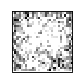

Iteration 302000: loss=0.00021417380776256323 prediction=2
Iteration 304000: loss=0.00022063276264816523 prediction=2
Iteration 306000: loss=0.00021587216178886592 prediction=2
Iteration 308000: loss=0.00021696234762202948 prediction=2
Iteration 310000: loss=0.00022158733918331563 prediction=2
Iteration 312000: loss=0.00021377738448791206 prediction=2
Iteration 314000: loss=0.0002233629347756505 prediction=2
Iteration 316000: loss=0.0002141762524843216 prediction=2
Iteration 318000: loss=0.00022063108917791396 prediction=2
Iteration 320000: loss=0.00021587198716588318 prediction=2


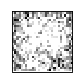

Iteration 322000: loss=0.00021696087787859142 prediction=2
Iteration 324000: loss=0.0002215873682871461 prediction=2
Iteration 326000: loss=0.00021377686061896384 prediction=2
Iteration 328000: loss=0.00022336181427817792 prediction=2
Iteration 330000: loss=0.00021417383686639369 prediction=2
Iteration 332000: loss=0.00022063108917791396 prediction=2
Iteration 334000: loss=0.00021587109949905425 prediction=2
Iteration 336000: loss=0.0002169633808080107 prediction=2
Iteration 338000: loss=0.00022158795036375523 prediction=2
Iteration 340000: loss=0.000213778272154741 prediction=2


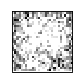

Iteration 342000: loss=0.0002233614941360429 prediction=2
Iteration 344000: loss=0.00021417478274088353 prediction=2
Iteration 346000: loss=0.0002206316275987774 prediction=2
Iteration 348000: loss=0.0002158720453735441 prediction=2
Iteration 350000: loss=0.00021696083422284573 prediction=2
Iteration 352000: loss=0.00022158745559863746 prediction=2
Iteration 354000: loss=0.000213777762837708 prediction=2
Iteration 356000: loss=0.00022336081019602716 prediction=2
Iteration 358000: loss=0.00021417354582808912 prediction=2
Iteration 360000: loss=0.00022063271899241954 prediction=2


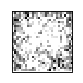

Iteration 362000: loss=0.00021587316587101668 prediction=2
Iteration 364000: loss=0.00021696244948543608 prediction=2
Iteration 366000: loss=0.00022158682986628264 prediction=2
Iteration 368000: loss=0.0002137783740181476 prediction=2
Iteration 370000: loss=0.00022336290567182004 prediction=2
Iteration 372000: loss=0.0002141741570085287 prediction=2
Iteration 374000: loss=0.00022063164215069264 prediction=2
Iteration 376000: loss=0.000215873631532304 prediction=2
Iteration 378000: loss=0.00021696032490581274 prediction=2
Iteration 380000: loss=0.0002215879940195009 prediction=2


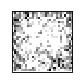

Iteration 382000: loss=0.00021377785014919937 prediction=2
Iteration 384000: loss=0.00022336188703775406 prediction=2
Iteration 386000: loss=0.0002141737350029871 prediction=2
Iteration 388000: loss=0.00022063015785533935 prediction=2
Iteration 390000: loss=0.000215873122215271 prediction=2
Iteration 392000: loss=0.0002169610233977437 prediction=2
Iteration 394000: loss=0.0002215896238340065 prediction=2
Iteration 396000: loss=0.0002137783740181476 prediction=2
Iteration 398000: loss=0.00022336184338200837 prediction=2
Iteration 400000: loss=0.00021417575771920383 prediction=2


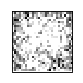

Iteration 402000: loss=0.00022063276264816523 prediction=2
Iteration 404000: loss=0.00021587211813312024 prediction=2
Iteration 406000: loss=0.00021696192561648786 prediction=2
Iteration 408000: loss=0.00022158682986628264 prediction=2
Loss is rising .. stop


In [114]:
new_image_randn = generate_image(img, 2)